# 0. Import library
- 필요한 라이브러리를 import합니다

In [29]:
import numpy as np
import pandas as pd 
import os

import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image 
import torch.nn as nn
from tqdm.auto import tqdm
import cv2
import torch.nn.functional as F
import random

import matplotlib.pyplot as plt

#실험 재현을 위한 랜덤시드 고정
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed(22)

# 1. Setting directory, device
- 작동하길 원하는 위치로 경로 설정을 합니다
- kaggle notebook 사용 시, 모든 경로를 그대로 사용하시면 됩니다.

In [30]:
#본인 환경에 맞는 데이터들이 있는 폴더의 위치를 입력 
os.chdir('/kaggle/input/ultrasound-image-classification-hallym/')

In [31]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

# 2. Preparing Dataset and Dataloader

In [32]:
# train.csv를 가져와 train,validation dataset으로 분리
df = pd.read_csv('./train.csv')
train_df, val_df, _, _ = train_test_split(df, df['Plane'].values, test_size=0.2, shuffle=True, stratify=df['Plane'].values, random_state=34)
train_df.head()
len(train_df)

4836

In [33]:
# 데이터 경로를 리턴해주는 함수를 통해 이미지 경로 추출
def get_data(df, test = False):
    if test is True:
        return "./test/"+df['Image_name'].values
    return "./train/"+df['Image_name'].values+'.png', df['Plane'].values

train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [34]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        image = Image.open(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_paths)

In [35]:
transform = transforms.Compose([#transforms의 최고의 조합을 찾기#Autoaugmentation을 해야함---->최적의 조합을 찾아주는 걸로 앎
                                transforms.Resize((256,256)),#사이즈 변환
                                transforms.RandomHorizontalFlip(),#뒤집기
                                transforms.RandomCrop(224),#자르기
                                transforms.RandomRotation(degrees=(-15,15)),#회전
                                transforms.ToTensor(),#변환
                                transforms.Normalize([0.485], [0.229]),#정규화
                               ])

In [9]:
# random_auto2_transform = transforms.AutoAugment(

#     transforms.AutoAugmentPolicy.IMAGENET,


# )

In [36]:
train_dataset = CustomDataset(train_img_paths, train_labels,transform)
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle=True)
val_dataset = CustomDataset(val_img_paths, val_labels,transform)
val_loader = DataLoader(val_dataset, batch_size = 4, shuffle=False)

# 3. Selecting model, Cost(Loss) Function, and Optimizer

In [37]:
# 모델 라이브러리 설치 및 임포트
!pip install timm 
import timm# ok
model = timm.create_model('tf_efficientnet_cc_b1_8e', pretrained=True, num_classes=8, in_chans=1)

In [12]:
# !pip3 install efficientnet_pytorch
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=8)
# #model = timm.create_model('', pretrained=True)

In [38]:
# nSamples =[282,698,300,236,413,846,785,1276]#facal Loss 
# normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
# normedWeights = torch.FloatTensor(normedWeights).to(device)
# normedWeights = normedWeights/9
# print(normedWeights)
weights = torch.FloatTensor([0.1046, 0.0951, 0.1042, 0.1057, 0.1016, 0.0917, 0.0931, 0.0818]).cuda()
criterion = torch.nn.CrossEntropyLoss(weight=weights,label_smoothing=0.01)#label_smoothing
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')

# 4. Train and validate the configured model

In [39]:
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)
model.to(device)

for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels in tqdm(val_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()
            
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    
    # calculate average losses
    valid_loss[e] /= len(val_loader)
    valid_acc[e] /= len(val_loader)
    
    scheduler.step(valid_loss[e])    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(),'/kaggle/working/model.pt') #모델파일이 저장되고자하는 경로 지정
        valid_loss_min = valid_loss[e]

  0%|          | 0/1209 [00:00<?, ?it/s]

KeyboardInterrupt: 

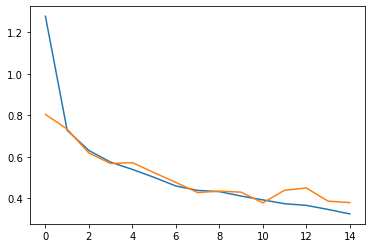

In [15]:
# loss graph 확인
plt.plot(train_loss)
plt.plot(valid_loss)

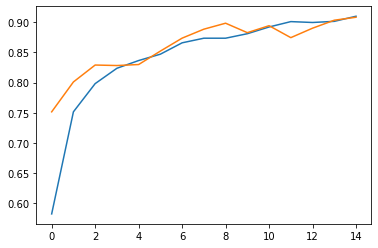

In [16]:
# accuracy graph 확인
plt.plot(train_acc)
plt.plot(valid_acc)

In [40]:
#model1 - tf_efficientnet_cc_b0_8e -> not ok
!pip install timm
import timm
model1 = timm.create_model('efficientnet_b0', pretrained=True, num_classes=8, in_chans=1)

In [42]:
# nSamples =[282,698,300,236,413,846,785,1276]#facal Loss 
# normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
# normedWeights = torch.FloatTensor(normedWeights).to(device)
# normedWeights = normedWeights/9
# print(normedWeights)
weights = torch.FloatTensor([0.1046, 0.0951, 0.1042, 0.1057, 0.1016, 0.0917, 0.0931, 0.0818]).cuda()
criterion = torch.nn.CrossEntropyLoss(weight=weights,label_smoothing=0.01)#label_smoothing
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')

In [86]:
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)
model1.to(device)

for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model1.train()
    for data, labels in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model1(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model1.eval()
        for data, labels in tqdm(val_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model1(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()
            
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    
    # calculate average losses
    valid_loss[e] /= len(val_loader)
    valid_acc[e] /= len(val_loader)
    
    scheduler.step(valid_loss[e])    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model1.state_dict(),'/kaggle/working/model1.pt') #모델파일이 저장되고자하는 경로 지정
        valid_loss_min = valid_loss[e]

  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 0.581522 	Validation Loss: 0.551689
Epoch: 0 	Training accuracy: 0.817618 	Validation accuracy: 0.853135
Validation loss decreased (inf --> 0.551689).  Saving model ...


  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.540271 	Validation Loss: 0.429007
Epoch: 1 	Training accuracy: 0.833954 	Validation accuracy: 0.879538
Validation loss decreased (0.551689 --> 0.429007).  Saving model ...


  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.516670 	Validation Loss: 0.518736
Epoch: 2 	Training accuracy: 0.842845 	Validation accuracy: 0.866337


  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.477765 	Validation Loss: 0.522226
Epoch: 3 	Training accuracy: 0.858768 	Validation accuracy: 0.870462


  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.449057 	Validation Loss: 0.474456
Epoch: 4 	Training accuracy: 0.869520 	Validation accuracy: 0.866337


  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.433226 	Validation Loss: 0.413604
Epoch: 5 	Training accuracy: 0.878205 	Validation accuracy: 0.884488
Validation loss decreased (0.429007 --> 0.413604).  Saving model ...


  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.406614 	Validation Loss: 0.451748
Epoch: 6 	Training accuracy: 0.877998 	Validation accuracy: 0.880363


  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.396701 	Validation Loss: 0.426219
Epoch: 7 	Training accuracy: 0.887717 	Validation accuracy: 0.881188


  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.373846 	Validation Loss: 0.407387
Epoch: 8 	Training accuracy: 0.893300 	Validation accuracy: 0.889439
Validation loss decreased (0.413604 --> 0.407387).  Saving model ...


  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.365778 	Validation Loss: 0.374162
Epoch: 9 	Training accuracy: 0.896816 	Validation accuracy: 0.891089
Validation loss decreased (0.407387 --> 0.374162).  Saving model ...


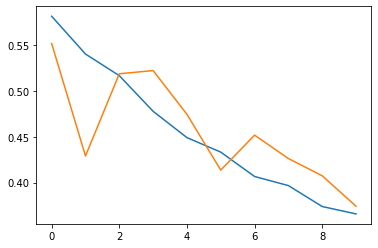

In [87]:
plt.plot(train_loss)
plt.plot(valid_loss)

In [80]:
# nSamples =[282,698,300,236,413,846,785,1276]#facal Loss 
# normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
# normedWeights = torch.FloatTensor(normedWeights).to(device)
# normedWeights = normedWeights/9
# print(normedWeights)
weights = torch.FloatTensor([0.1046, 0.0951, 0.1042, 0.1057, 0.1016, 0.0917, 0.0931, 0.0818]).cuda()
criterion = torch.nn.CrossEntropyLoss(weight=weights,label_smoothing=0.01)#label_smoothing
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')

In [81]:
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)
model2.to(device)

for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model2.train()
    for data, labels in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model2(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model2.eval()
        for data, labels in tqdm(val_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model2(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()
            
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    
    # calculate average losses
    valid_loss[e] /= len(val_loader)
    valid_acc[e] /= len(val_loader)
    
    scheduler.step(valid_loss[e])    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model2.state_dict(),'/kaggle/working/model2.pt') #모델파일이 저장되고자하는 경로 지정
        valid_loss_min = valid_loss[e]

  0%|          | 0/1209 [00:00<?, ?it/s]

KeyboardInterrupt: 

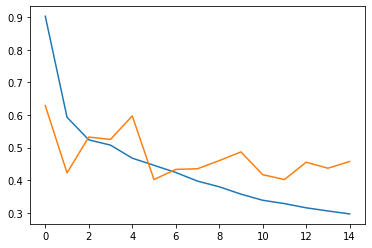

In [39]:
plt.plot(train_loss)
plt.plot(valid_loss)

In [43]:
#model3 - efficientnet_lite0 -> ok
!pip install timm
import timm
model3 = timm.create_model('efficientnet_lite0', pretrained=True, num_classes=8, in_chans=1)

In [44]:
nSamples =[282,698,300,236,413,846,785,1276]
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights).to(device)
normedWeights = normedWeights/8

weights = torch.FloatTensor([0.1046, 0.0951, 0.1042, 0.1057, 0.1016, 0.0917, 0.0931, 0.0818]).cuda()
criterion = torch.nn.CrossEntropyLoss(weight=weights,label_smoothing=0.01)#label_smoothing
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')

In [45]:
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)
model3.to(device)

for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model3.train()
    for data, labels in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model3(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model3.eval()
        for data, labels in tqdm(val_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model3(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()
            
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    
    # calculate average losses
    valid_loss[e] /= len(val_loader)
    valid_acc[e] /= len(val_loader)
    
    scheduler.step(valid_loss[e])    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model3.state_dict(),'/kaggle/working/model3.pt') #모델파일이 저장되고자하는 경로 지정
        valid_loss_min = valid_loss[e]

  0%|          | 0/1209 [00:00<?, ?it/s]

KeyboardInterrupt: 

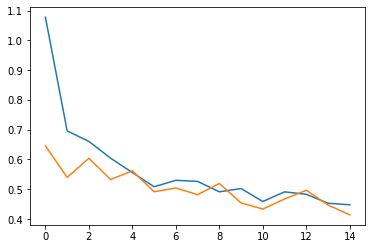

In [78]:
plt.plot(train_loss)
plt.plot(valid_loss)

# 5. Preparing Test data

In [46]:
test_df = pd.read_csv('./sample_submission.csv')
test_img_paths = get_data(test_df,test=True)

In [47]:
test_transform = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.Grayscale(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485], [0.229])
                                    ])

In [48]:
test_dataset = CustomDataset(test_img_paths,transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size=4,shuffle=False)

# 6. Inference

In [16]:
#학습시킨 모델 로드
#model1 - tf_efficientnet_cc_b1_8e
model = timm.create_model('tf_efficientnet_cc_b1_8e', pretrained=True, num_classes=8, in_chans=1)
model.load_state_dict(torch.load('/kaggle/working/model.pt'))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_cc_b1_8e-f7c79ae1.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_cc_b1_8e-f7c79ae1.pth


In [51]:
pred0 = []
li0 = []
model.to(device)
with torch.no_grad(): 
    model.eval()
    for images in tqdm(test_loader):
        images = images.to(device)
        logits = model(images)
        li0.append(logits)
        pred0+=logits.argmax(1).detach().cpu().numpy().tolist()

  0%|          | 0/1311 [00:00<?, ?it/s]

In [49]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# cf = confusion_matrix(label, pred)
# print(cf)
# #efficientnet_b0 efficientnet_b1 efficientnet_b3a efficientnet-lite0

NameError: name 'label' is not defined

In [51]:
!pip install timm 
import timm
import torch
model1 = timm.create_model('efficientnet_b0', pretrained=True, num_classes=8, in_chans=1)
model1.load_state_dict(torch.load('/kaggle/working/model1.pt'))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/model1.pt'

In [89]:
pred1 = []
li1 = []
model1.to(device)
with torch.no_grad(): 
    model1.eval()
    for images in tqdm(test_loader):
        
        images = images.to(device)
        logits2 = model1(images)
        li1.append(logits2)
        pred1+=logits2.argmax(1).detach().cpu().numpy().tolist()

  0%|          | 0/1311 [00:00<?, ?it/s]

In [14]:
# model2 = timm.create_model('efficientnet_b3a', pretrained=True, num_classes=8, in_chans=1)
# # model2.load_state_dict(torch.load('/kaggle/working/model2.pt'))

In [56]:
# pred2 = []
# li2 = []
# model2.to(device)
# with torch.no_grad(): 
#     model2.eval()
#     for images in tqdm(test_loader):
#         images = images.to(device)
#         logits1 = model2(images)
#         li2.append(logits1)
#         pred2+=logits1.argmax(1).detach().cpu().numpy().tolist()

  0%|          | 0/1311 [00:00<?, ?it/s]

In [23]:

model3 = timm.create_model('efficientnet_lite0', pretrained=True, num_classes=8, in_chans=1)
model3.load_state_dict(torch.load('/kaggle/working/model3.pt'))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_lite0_ra-37913777.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_lite0_ra-37913777.pth


In [60]:
pred3 = []
li3 = []
model3.to(device)
with torch.no_grad(): 
    model3.eval()
    for images in tqdm(test_loader):
        images = images.to(device)
        logits1 = model3(images)
        li3.append(logits1)
        pred3+=logits1.argmax(1).detach().cpu().numpy().tolist()

  0%|          | 0/1311 [00:00<?, ?it/s]

In [105]:
li4 = []
for i in range(1311):
    prediction = np.mean( np.array([li2[i].cpu().numpy(),li3[i].cpu().numpy(),li0[i].cpu().numpy()]), axis=0 )
    li4.append(prediction.argmax(1))
li4 = np.array(li4)
li4 = li4.flatten()

# 7. Printing GFLOPs

- 아래 코드 및 결과 스크린샷 보고서에 추가 필수
- inputs 변수 자기가 학습시킨 input size로 세팅할 것.(이에 따라 gflops가 바뀌니 꼭 유의할 것)
- 앙상블 사용 시, 사용한 모든 모델의 gflops 계산 후 더한 것이 최종 gflops

In [9]:
!pip install thop

#### **★ inputs 변수는 자신의 model input size로 꼭 세팅 (batch size도 train했을 때와 동일하게 할 것) ★**

In [28]:
from thop import profile

batch_size, image_channel, image_h, image_w = 1,1,224,224
inputs = torch.randn(batch_size, image_channel, image_h, image_w).to(device) 
macs, params = profile(model1.to(device), inputs=(inputs, ))
flops = macs*2
gflops = round(flops/1000000000,7)
print("내 모델의 FLOPs : ",gflops, "GFLOP")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
내 모델의 FLOPs :  1.5095346 GFLOP


# 8. Make submission

* 제출 csv파일명 변경 금지

In [111]:
# predict result로 제출 csv 작성
submission = pd.read_csv("./sample_submission.csv")
submission["Plane"] = li4
file_name=f"/kaggle/working/submission_{gflops}.csv"
submission.to_csv(file_name, index = False)